# 3-D Exodus example

Anthony Gruber 3-31-2023

In [1]:
# Imports for exodus
import sys
sys.path.append('/Users/adgrube/Desktop/Code/seacas/lib')  ### replace with your Seacas installation
import exodus

# Standard imports
import numpy as np
# from scipy.linalg import svd
from scipy.sparse import eye, csc_matrix
from scipy.sparse.linalg import spsolve, inv
from scipy.io import mmread, loadmat
import matplotlib.pyplot as plt

# Import for utils
sys.path.append("..")

import OpInf_utils as ou
import ROM_utils as ru

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

# Creating exodus file
fromFileName = 'beam_velIC_100.e'
toFileName   = 'beam_vecIC_100_written.e'

massName  = 'mass.mm'
stiffName = 'stiff.mm'

ROMvariables = ['exactSol_x', 'exactSol_y', 'exactSol_z',
                '1-disp_G-OpRom_x', '1-disp_G-OpRom_y', '1-disp_G-OpRom_z',
                '1-disp_NC-H-OpRom_x', '1-disp_NC-H-OpRom_y', '1-disp_NC-H-OpRom_z',
                '1-disp_C-H-OpRom_x', '1-disp_C-H-OpRom_y', '1-disp_C-H-OpRom_z',
                '1-disp_G-IntRom_x', '1-disp_G-IntRom_y', '1-disp_G-IntRom_z',
                '1-disp_H-IntRom_x', '1-disp_H-IntRom_y', '1-disp_H-IntRom_z',
                '2-disp_G-OpRom_x', '2-disp_G-OpRom_y', '2-disp_G-OpRom_z',
                '2-disp_NC-H-OpRom_x', '2-disp_NC-H-OpRom_y', '2-disp_NC-H-OpRom_z',
                '2-disp_C-H-OpRom_x', '2-disp_C-H-OpRom_y', '2-disp_C-H-OpRom_z',
                '2-disp_G-IntRom_x', '2-disp_G-IntRom_y', '2-disp_G-IntRom_z',
                '2-disp_H-IntRom_x', '2-disp_H-IntRom_y', '2-disp_H-IntRom_z',
                '3-disp_G-OpRom_x', '3-disp_G-OpRom_y', '3-disp_G-OpRom_z',
                '3-disp_NC-H-OpRom_x', '3-disp_NC-H-OpRom_y', '3-disp_NC-H-OpRom_z',
                '3-disp_C-H-OpRom_x', '3-disp_C-H-OpRom_y', '3-disp_C-H-OpRom_z',
                '3-disp_G-IntRom_x', '3-disp_G-IntRom_y', '3-disp_G-IntRom_z',
                '3-disp_H-IntRom_x', '3-disp_H-IntRom_y', '3-disp_H-IntRom_z']

# # Use this the first time the file is created
# exo_copy = exodus.copyTransfer(fromFileName, toFileName,
#                                array_type='numpy',
#                                additionalNodalVariables=ROMvariables)

#Use this after file is created
exo_copy = exodus.exodus(f'{toFileName}', array_type='numpy')


You are using exodus.py v 1.20.17 (seacas-py3), a python wrapper of some of the exodus library.

Copyright (c) 2013-2022 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: beam_vecIC_100_written.e


### Function which grabs snapshots from Irina's data and assembles FOM quantities

In [2]:
# Function which grabs everything from the exodus file
# The snapshots are kind of weird -- energy drops after first iteration

def assemble_FOM(exo_file):
    # Import mass and stiffness matrices
    N     = exo_file.num_nodes()
    Nt    = exo_file.num_times()
    mass  = mmread(massName)
    stiff = mmread(stiffName)

    # stiff = 0.5 * (stiff+stiff.T)
    # mass  = 0.5 * (mass+mass.T)
    M = mass.todense()
    K = stiff.todense()


    # Build L matrix
    zz    = np.zeros((3*N, 3*N))
    ii    = np.eye(3*N)
    J     = np.block([[zz, ii], [-ii, zz]])

    # BCset = [0,0,0,0,0,0]
    # BCdofs = []
    # for i in range(6):
    #     BCset[i] = exo_file.get_node_set_nodes(i+1)
    # for i in range(2):
    #     xdofs = (BCset[i]-1)*3 + 0
    #     BCdofs.append(xdofs)
    # for i in range(2,4):
    #     ydofs = (BCset[i]-1)*3 + 1
    #     BCdofs.append(ydofs)
    # for i in range(4,6):
    #     zdofs = (BCset[i]-1)*3 + 2
    #     BCdofs.append(zdofs)

    # BCdofs = np.concatenate(BCdofs, axis=0)

    # ii[BCdofs] = np.zeros(3*N)
    # J     = np.block([[zz, ii], [-ii, zz]])

    # for grad H
    massInv = spsolve(mass.tocsc(), eye(3*N).tocsc())
    A       = np.block([[stiff.todense(), zz], [zz, massInv.todense()]])

    # Solution arrays ordered by node_id
    sol_x   = np.zeros((N, Nt))
    sol_y   = np.zeros((N, Nt))
    sol_z   = np.zeros((N, Nt))

    # for position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('disp_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('disp_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('disp_z', t+1)

    # Full position array (interleaved like M, K matrices)
    q_arr       = np.zeros((3*N, Nt))
    q_arr[0::3] = sol_x
    q_arr[1::3] = sol_y
    q_arr[2::3] = sol_z

    # for derivative of position
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dot_z', t+1)

    # Full qDot array
    qDot_arr       = np.zeros((3*N, Nt))
    qDot_arr[0::3] = sol_x
    qDot_arr[1::3] = sol_y
    qDot_arr[2::3] = sol_z

    # Full momentum array (interleaved)
    p_arr = mass @ qDot_arr

    # for derivative of momentum
    for t in range(Nt):
        sol_x[:,t] = exo_file.get_node_variable_values('solution_dotdot_x', t+1)
        sol_y[:,t] = exo_file.get_node_variable_values('solution_dotdot_y', t+1)
        sol_z[:,t] = exo_file.get_node_variable_values('solution_dotdot_z', t+1)

    # Full pDot array
    pDot_arr       = np.zeros((3*N, Nt))
    pDot_arr[0::3] = sol_x
    pDot_arr[1::3] = sol_y
    pDot_arr[2::3] = sol_z
    pDot_arr       = mass @ pDot_arr

    # Build state, state derivative, and gradH
    x_arr     = np.concatenate((q_arr, p_arr), axis=0)
    xDot_arr  = np.concatenate((qDot_arr, pDot_arr), axis=0)
    gradH_arr = csc_matrix(A) @ x_arr

    return (x_arr, xDot_arr, gradH_arr), J, A


# Compute Hamiltonian
def Hamil(data, A):
    result = np.zeros(data.shape[1])
    for i in range(len(result)):
        result[i] = data[:,i].T @ A @ data[:,i]
    return 0.5 * result

## Computing the FOM solution in Hamiltonian form and building POD basis

In [3]:
# Get data from exodus file (201 snaps)
data, J, A     = assemble_FOM(exo_copy)
Asp            = csc_matrix(A)
Jsp            = csc_matrix(J)

# Doing the integration (takes about 2:40)
tTrain = np.linspace(0, 0.02, 201)
Xt, Xdt, gHt = ru.integrate_Linear_HFOM(tTrain, data[0][:,0], Jsp, Asp)

#Saving the data
# dicto = {'x': Xt, 'xDot': Xdt, 'gradH': gHt}
# from scipy.io import savemat
# savemat('exo_snap201.mat', dicto)

# # Ignore exodus file and get data from Hamiltonian system
# mat            = loadmat('clamped/exo_snaps.mat')
# xData          = mat['x']
# xDotData       = mat['xDot']
# gradHData      = mat['gradH']

xData, xDotData, gradHData = Xt, Xdt, gHt
# # xData, xDotData, gradHData = data
xData.shape

(10584, 201)

## Computing POD bases and snapshot plots

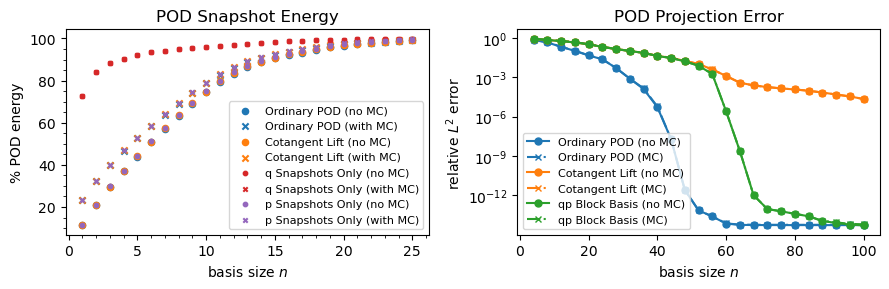

In [4]:
POD   = ru.Linear_Hamiltonian_ROM(Xt)
POD.set_reduced_basis('POD', rmax=100, randomized=True)
POD.compute_basis_energies()
PODmc = ru.Linear_Hamiltonian_ROM(Xt)
PODmc.set_reduced_basis('POD', centered=True, rmax=100, randomized=True)
PODmc.compute_basis_energies()
CL    = ru.Linear_Hamiltonian_ROM(Xt)
CL.set_reduced_basis('cotangent_lift', rmax=100, randomized=True)
CL.compute_basis_energies()
CLmc  = ru.Linear_Hamiltonian_ROM(Xt)
CLmc.set_reduced_basis('cotangent_lift', centered=True, rmax=100, randomized=True)
CLmc.compute_basis_energies()
QP    = ru.Linear_Hamiltonian_ROM(Xt)
QP.set_reduced_basis('block_qp', rmax=100, randomized=True)
QP.compute_basis_energies()
QPmc  = ru.Linear_Hamiltonian_ROM(Xt)
QPmc.set_reduced_basis('block_qp', centered=True, rmax=100, randomized=True)
QPmc.compute_basis_energies()
QQ    = ru.Linear_Hamiltonian_ROM(Xt)
QQ.set_reduced_basis('block_qq', rmax=100, randomized=True)
QQ.compute_basis_energies()
QQmc  = ru.Linear_Hamiltonian_ROM(Xt)
QQmc.set_reduced_basis('block_qq', centered=True, rmax=100, randomized=True)
QQmc.compute_basis_energies()

SS, SSmc     = POD.basis_evals, PODmc.basis_evals
SS2, SS2mc   = CL.basis_evals, CLmc.basis_evals
SSq, SSp     = QP.basis_evals
SSqmc, SSpmc = QPmc.basis_evals

nEigs = 25
idx = [i+1 for i in range(nEigs)]

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(25)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):

    reconUmc   = PODmc.project(Xt, n)
    reconU     = POD.project(Xt, n)
    reconU2mc  = CLmc.project(Xt, n)
    reconU2    = CL.project(Xt, n)
    reconUqpmc = QPmc.project(Xt, n)
    reconUqp   = QP.project(Xt, n)

    errUmc[i]   = ru.relError(Xt, reconUmc)
    errU[i]     = ru.relError(Xt, reconU)
    errU2mc[i]  = ru.relError(Xt, reconU2mc)
    errU2[i]    = ru.relError(Xt, reconU2)
    errUqpmc[i] = ru.relError(Xt, reconUqpmc)
    errUqp[i]   = ru.relError(Xt, reconUqp)


from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, POD.basis_energies[:nEigs], s=20., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, PODmc.basis_energies[:nEigs], s=20., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, CL.basis_energies[0][:nEigs], s=20., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, CLmc.basis_energies[0][:nEigs], s=20., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, QP.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, QPmc.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, QP.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, QPmc.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('WavePODenergy', transparent=True)
plt.show()

## Computing the ROMs

Here I compute all of the relevant ROM solutions and plot the errors (predictive case)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


/Users/adgrube/Desktop/Code/HamiltonianOpInf/CantileverPlate/../ROM_utils.py:201: RuntimeWarning: overflow encountered in matmul
  rhs          = dt * (self.x0b4JA + JA_hat @ x_hat[:,i])


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
0 the relative L2 errors for intrusive GROM are [5.66657474e+02 3.02357878e+17 2.29649182e+10 1.69457577e+00
 1.00000000e+00 1.40197914e+09 2.66341911e+10 6.56114165e+16
 1.42862353e+24 2.70983262e-02]
0 the relative L2 errors for intrusive HROM are [1.71660743 1.6743533  1.45031264 1.40524684 1.20685893 0.78155394
 0.77319317 0.17657773 0.05778715 0.00184522]
0 the relative L2 errors for generic OpInf are [5.66657474e+02 3.02357878e+17 2.29649182e+10 1.69457577e+00
 1.00000000e+00 1.40197914e+09 2.66341911e+10 6.56114165e+16
 1.42862353e+24 2.70983262e-02]
0 th

/Users/adgrube/Desktop/Code/HamiltonianOpInf/CantileverPlate/../ROM_utils.py:634: RuntimeWarning: overflow encountered in matmul
  result[i] = data[:,i].T @ A @ data[:,i]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
2 the relative L2 errors for intrusive GROM are [1.32059495e+00 9.40121703e-01 1.38559425e+00 4.85585686e+22
 3.95019173e+00            inf 5.11582364e-01 6.19802242e-01
 1.22209033e-01 4.65519089e+94]
2 the relative L2 errors for intrusive HROM are [1.36996451 1.03466605 0.90741806 0.60339246 0.5202416  0.32751116
 0.30204114 0.16288059 0.09211897 0.08732004]
2 the relative L2 errors for generic OpInf are [1.32059495e+00 9.40121703e-01 1.38559425e+00 4.85585686e+22
 3.95019173e+00            inf 5.11582364e-01 6.19802239e-01
 1.22209033e-01 4.65519286e+94]
2 the relative L2 errors for noncanonical Hamiltonia

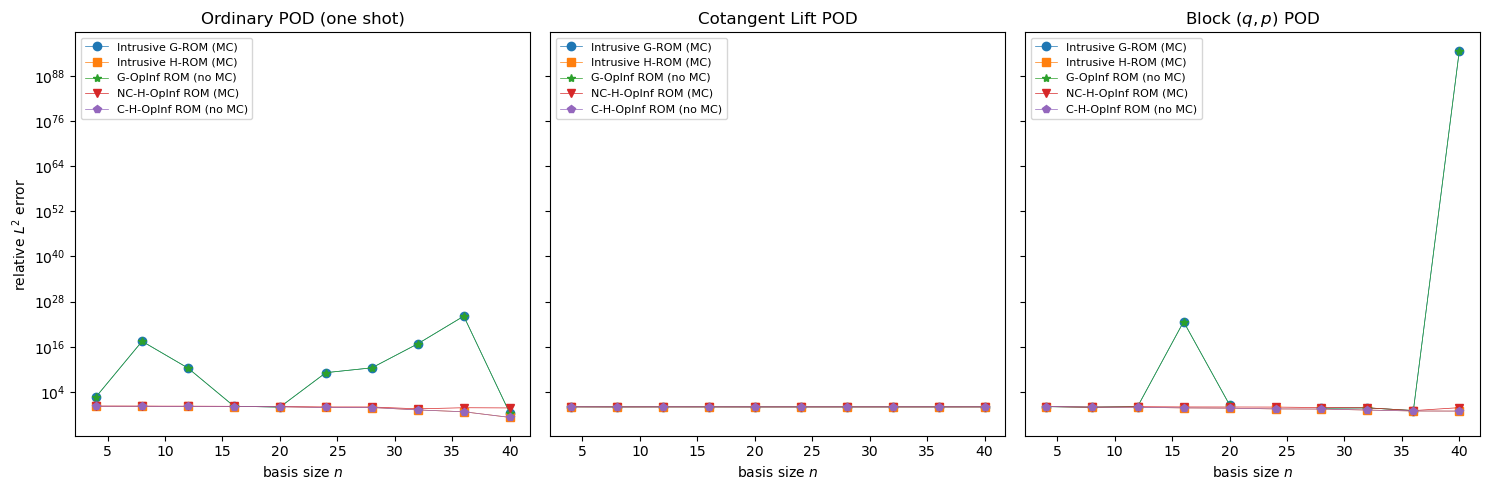

In [5]:
Asp = csc_matrix(A)

### Exact solution
Ttest     = 1e-1
NtTest    = 201
tTest     = np.linspace(0, Ttest, NtTest)
Xac       = ru.integrate_Linear_HFOM(tTest, data[0][:,0], J, A)[0]
exactE    = ru.compute_Hamiltonian(Xac, Asp)
N         = len(data[0][:,0])

### Parameters
rom_list = [PODmc, CLmc, QPmc]
nList = [4*(i+1) for i in range(10)]

eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), N, NtTest))
XrecIntH = np.zeros((3, len(nList), N, NtTest))
XrecOp   = np.zeros((3, len(nList), N, NtTest))
XrecOpH  = np.zeros((3, len(nList), N, NtTest))
XrecOpA  = np.zeros((3, len(nList), N, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']
alpha=1

for i in range(len(rom_list)):

    rom = rom_list[i]

    rom.A = Asp

    for j,n in enumerate(nList):

        rom.assemble_Hamiltonian_ROM(n, J, A)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=False) 
            XrecIntH[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.assemble_naive_ROM(n, J, A)
        try:
            rom.integrate_naive_ROM(tTest) 
            XrecIntG[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_generic(n, Xt, Xdt, eps=0.0e-5, reproject=True)
        try: 
            rom.integrate_naive_ROM(tTest)
            XrecOp[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_canonical_Hamiltonian(n, Xt, Xdt, J, eps=0.0e-5, old=False, reproject=True)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=False)
            XrecOpA[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_noncanonical_Hamiltonian(n, Xdt, gHt, A)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, inconsistent=True)
            XrecOpH[i,j] = rom.decode(rom.x_hat)
        except: pass
        # if i==1:
        #     opinf_rom.infer_SKZ_Hamiltonian(n, X1, Xt1, J)
        #     opinf_rom.integrate_Hamiltonian_ROM(tTest)
        #     XrecOpH[i,j] = opinf_rom.decode(opinf_rom.x_hat)
        # else:
        #     XrecOpH[i,j] = np.zeros_like(XrecIntG[i,j])

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        HamileIntG[i,j] = ru.compute_Hamiltonian(XrecIntG[i,j], Asp) - exactE
        HamileIntH[i,j] = ru.compute_Hamiltonian(XrecIntH[i,j], Asp) - exactE
        HamileOp[i,j]   = ru.compute_Hamiltonian(XrecOp[i,j], Asp) - exactE
        HamileOpH[i,j]  = ru.compute_Hamiltonian(XrecOpH[i,j], Asp) - exactE
        HamileOpA[i,j]  = ru.compute_Hamiltonian(XrecOpA[i,j], Asp) - exactE

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    # ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

0 the relative L2 errors for intrusive GROM are [5.66657474e+002 3.02357878e+017 2.29649182e+010 1.69457577e+000
 1.00000000e+000 1.40197914e+009 2.66341911e+010 6.56114162e+016
 1.42862351e+024 2.70983262e-002 3.78668516e-005 1.00044853e-008
 3.05807054e-001 1.42520956e+034 3.45706078e+086 7.79889214e+037
 3.50256754e+051 9.81911788e+045 1.28837831e+040 8.06674173e+118
 1.21077389e+067 2.86179841e+022 3.37441354e+010 7.54238719e+012
 3.52308065e+000]
0 the relative L2 errors for intrusive HROM are [1.71660743e+00 1.67435330e+00 1.45031264e+00 1.40524684e+00
 1.20685893e+00 7.81553935e-01 7.73193171e-01 1.76577732e-01
 5.77871471e-02 1.84522412e-03 1.32054088e-06 1.97096872e-10
 1.55377069e-11 1.52815192e-11 1.54663841e-11 1.54353796e-11
 1.54374427e-11 1.53802377e-11 1.55160296e-11 1.54333375e-11
 1.54652855e-11 1.55968651e-11 1.53919745e-11 1.54333949e-11
 1.55347559e-11]
0 the relative L2 errors for generic OpInf are [5.66657474e+002 3.02357878e+017 2.29649182e+010 1.69457577e+000
 

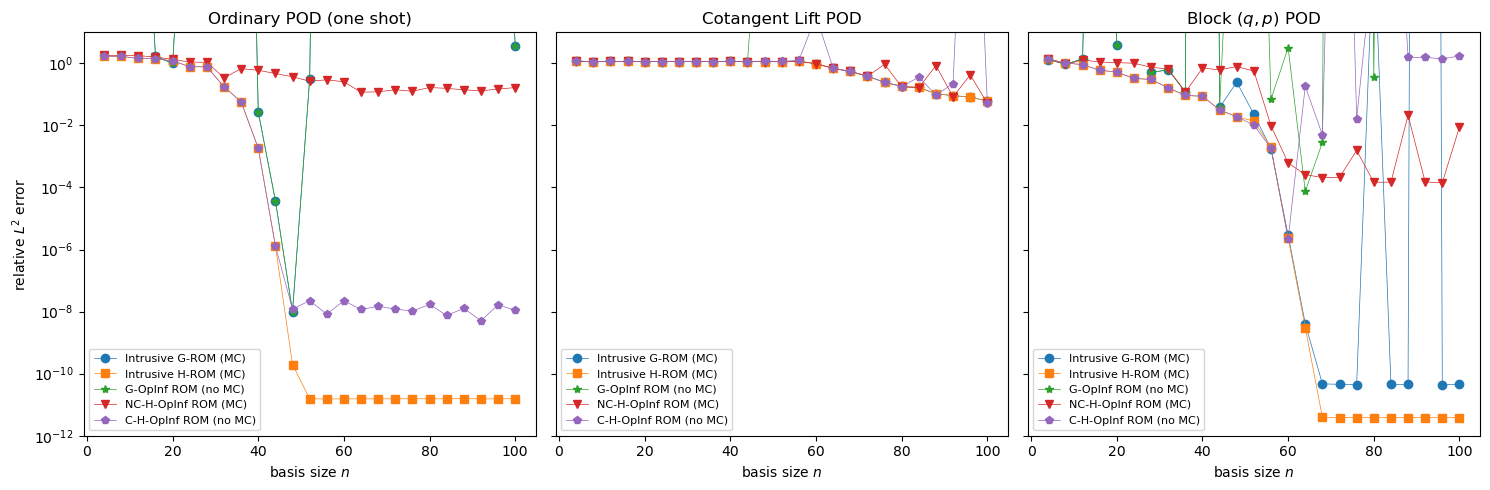

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']
alpha=1

for i in range(len(rom_list)):

    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-12, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=3)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

the relative L2 errors for Lagrangian GROM are [3.72428114e-01 3.00466244e-01 9.24562680e-02 3.36678103e-02
 9.33102090e-03 8.16175814e-03 3.39743818e-04 2.23021306e-04
 1.36413096e-04 7.91196474e-05 6.40605432e-05 6.16019722e-05
 6.08328776e-05 5.25581177e-05 5.45068018e-05 5.03870604e-05
 5.03626235e-05 5.02902873e-05 5.52203579e-05 5.36999277e-05
 5.57551906e-05 5.43199337e-05 4.85250171e-05 4.55385575e-05
 4.51743969e-05]
the relative L2 errors for Lagrangian HROM are [4.07343823e-02 2.16010275e-02 1.20865491e-02 5.43700246e-03
 3.72657084e-03 5.85248935e-04 4.52447384e-05 4.27339695e-05
 4.48726590e-05 4.51262536e-05 4.51480599e-05 4.51842961e-05
 4.52674439e-05 4.52657078e-05 4.52694312e-05 4.52733982e-05
 4.52768391e-05 4.52930299e-05 4.52990058e-05 4.53077648e-05
 4.53102986e-05 4.53128436e-05 4.53189006e-05 4.53233943e-05
 4.53309499e-05]
the relative L2 errors for intrusive HROM are [2.30830330e+01 2.31271862e+01 2.24855354e+01 1.86993176e+01
 1.49003218e+01 1.77166291e-01 1.

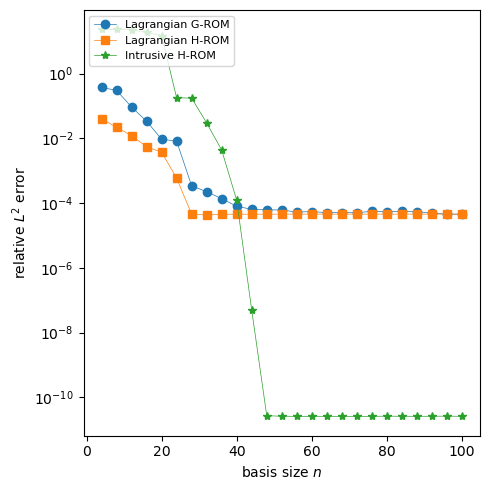

In [6]:
M    = csc_matrix(mmread(massName))
K    = csc_matrix(mmread(stiffName))

Qt   = Xt[:N//2]
Qdt  = Xdt[:N//2]
Qddt = inv(M) @ Xdt[-N//2:]

nList = [4*(i+1) for i in range(25)]

lag_rom = ru.Linear_Lagrangian_ROM(Qt)
lag_rom.set_reduced_basis('POD', centered=False)

QrecIntLag = np.zeros((len(nList), int(N//2), len(tTest)))
QrecIntHam = np.zeros((len(nList), int(N//2), len(tTest)))

eIntLag  = np.zeros(len(nList))
eIntHam  = np.zeros(len(nList))
eIntHam2 = np.zeros(len(nList))

for j,n in enumerate(nList):
    
    lag_rom.assemble_Lagrangian_ROM(n, M, K, Qdt, Qddt)
    try:
        lag_rom.integrate_Lagrangian_ROM(tTest)
        QrecIntLag[j] = lag_rom.decode(lag_rom.q_hat)
    except: pass
    eIntLag[j] = ru.relError(QrecIntLag[j], Xac[:N//2])
    lag_rom.assemble_Hamiltonian_from_Lagrangian_ROM(n, M, K, Qdt)
    # try:
    lag_rom.integrate_Hamiltonian_from_Lagrangian_ROM(tTest)
    QrecIntHam[j] = lag_rom.decode(lag_rom.q_hat)
    # except: pass
    eIntHam[j]  = ru.relError(QrecIntHam[j], Xac[:N//2])
    eIntHam2[j] = ru.relError(XrecIntH[0,j][:N//2], Xac[:N//2])


fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_ylabel('relative $L^2$ error')

# Print error magnitudes
print(f'the relative L2 errors for Lagrangian GROM are {eIntLag}')
print(f'the relative L2 errors for Lagrangian HROM are {eIntHam}')
print(f'the relative L2 errors for intrusive HROM are {eIntHam2}')

ax.semilogy(nList, eIntLag, label='Lagrangian G-ROM', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
ax.semilogy(nList, eIntHam, label='Lagrangian H-ROM', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
ax.semilogy(nList, eIntHam2, label='Intrusive H-ROM', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
# ax.set_ylim([10**-5, 10.])
# ax.set_title(f'{titleList[i]}')
ax.legend(prop={'size':8}, loc=2)
ax.set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()


NameError: name 'UmatList' is not defined

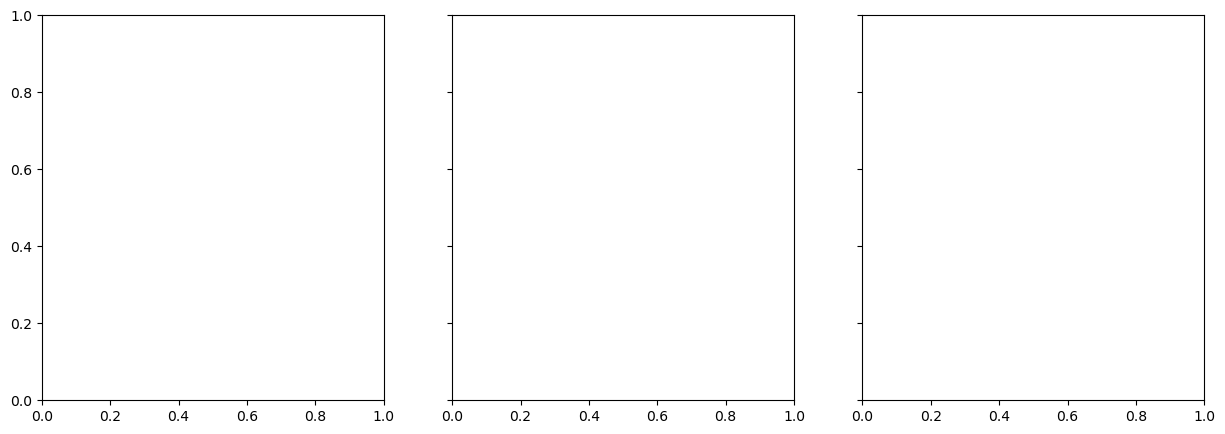

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
                'Block (q,p) POD']

float_formatter = "{:.2e}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

alpha=1

for i in range(len(UmatList)):

    # # Print error magnitudes
    # print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    # print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    # print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    # print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    # print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_xlabel('basis size $n$')
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=3)
    ax.flatten()[i].set_ylim([10**-9, 10.])

ax.flatten()[0].set_ylabel(r'relative $L^2$ error')
# ax.flatten()[0].set_ylim([10**-4, 10.])
# ax.flatten()[1].set_ylim([10**-4, 10.])
# ax.flatten()[2].set_ylim([10**-4, 10.])
plt.tight_layout()
# plt.savefig(f'PlatePlotPredZoom', transparent=True)
plt.show()


# fig, ax = plt.subplots(1, 1, figsize=(5,5))

# ax.semilogy(nList, eIntG[2], label='Intrusive G-ROM (block (q,p))', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eIntH[1], label='Intrusive H-ROM (cotangent lift)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOp[2],  label='G-OpInf ROM (block (q,p))', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOpH[2], label='NC-H-OpInf ROM (block (q,p))', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.semilogy(nList, eOpA[1], label='C-H-OpInf ROM (cotangent lift)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
# ax.set_xlabel('basis size $n$')
# ax.set_title('ROM Results')
# ax.legend(prop={'size':8}, loc=3)
# ax.set_ylim([10**-5, 10.])

# ax.set_ylabel(r'relative $L^2$ error')
# # ax.flatten()[0].set_ylim([10**-4, 10.])
# # ax.flatten()[1].set_ylim([10**-4, 10.])
# # ax.flatten()[2].set_ylim([10**-4, 10.])
# plt.tight_layout()
# plt.savefig(f'best_cases_for_Irina', transparent=True)
# plt.show()

### Saving solution data to Exodus file

Commented so as not to mess with running this

In [ ]:
# N = 1764

# iList = [2, 1, 2]
# jList = [24, 23, 23]

# disp_xTest  = Xac[::3][:N]
# disp_yTest  = Xac[1::3][:N]
# disp_zTest  = Xac[2::3][:N]

# for k in range(201):
#     exo_copy.put_node_variable_values("exactSol_x", k+1, disp_xTest[:,k])
#     exo_copy.put_node_variable_values("exactSol_y", k+1, disp_yTest[:,k])
#     exo_copy.put_node_variable_values("exactSol_z", k+1, disp_zTest[:,k])

# for l in range(3):
#     i = iList[l]
#     j = jList[l]

#     print(f'num modes is {4*(j+1)}')
#     print(f'errors are' + '\n' + f'{eIntG[i,j]}' + '\n' + f'{eIntH[i,j]}' + '\n' 
#           + f'{eOp[i,j]}' + '\n' + f'{eOpH[i,j]}' + '\n' + f'{eOpA[i,j]}' + '\n')

#     disp_xRecIntG = XrecIntG[i,j][::3][:N]
#     disp_yRecIntG = XrecIntG[i,j][1::3][:N]
#     disp_zRecIntG = XrecIntG[i,j][2::3][:N]

#     disp_xRecIntH = XrecIntH[i,j][::3][:N]
#     disp_yRecIntH = XrecIntH[i,j][1::3][:N]
#     disp_zRecIntH = XrecIntH[i,j][2::3][:N]

#     disp_xRecOpH = XrecOpH[i,j][::3][:N]
#     disp_yRecOpH = XrecOpH[i,j][1::3][:N]
#     disp_zRecOpH = XrecOpH[i,j][2::3][:N]

#     disp_xRecOpA = XrecOpA[i,j][::3][:N]
#     disp_yRecOpA = XrecOpA[i,j][1::3][:N]
#     disp_zRecOpA = XrecOpA[i,j][2::3][:N]

#     disp_xRecOp  = XrecOp[i,j][::3][:N]
#     disp_yRecOp  = XrecOp[i,j][1::3][:N]
#     disp_zRecOp  = XrecOp[i,j][2::3][:N]

#     for k in range(201):
#         exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_x", k+1, disp_xRecIntG[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_y", k+1, disp_yRecIntG[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_G-IntRom_z", k+1, disp_zRecIntG[:,k])

#         exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_x", k+1, disp_xRecIntH[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_y", k+1, disp_yRecIntH[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_H-IntRom_z", k+1, disp_zRecIntH[:,k])

#         exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_x", k+1, disp_xRecOpH[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_y", k+1, disp_yRecOpH[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_NC-H-OpRom_z", k+1, disp_zRecOpH[:,k])

#         exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_x", k+1, disp_xRecOpA[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_y", k+1, disp_yRecOpA[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_C-H-OpRom_z", k+1, disp_zRecOpA[:,k])

#         exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_x", k+1, disp_xRecOp[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_y", k+1, disp_yRecOp[:,k])
#         exo_copy.put_node_variable_values(f"{l+1}-disp_G-OpRom_z", k+1, disp_zRecOp[:,k])

### Plots of Hamiltonian conservation

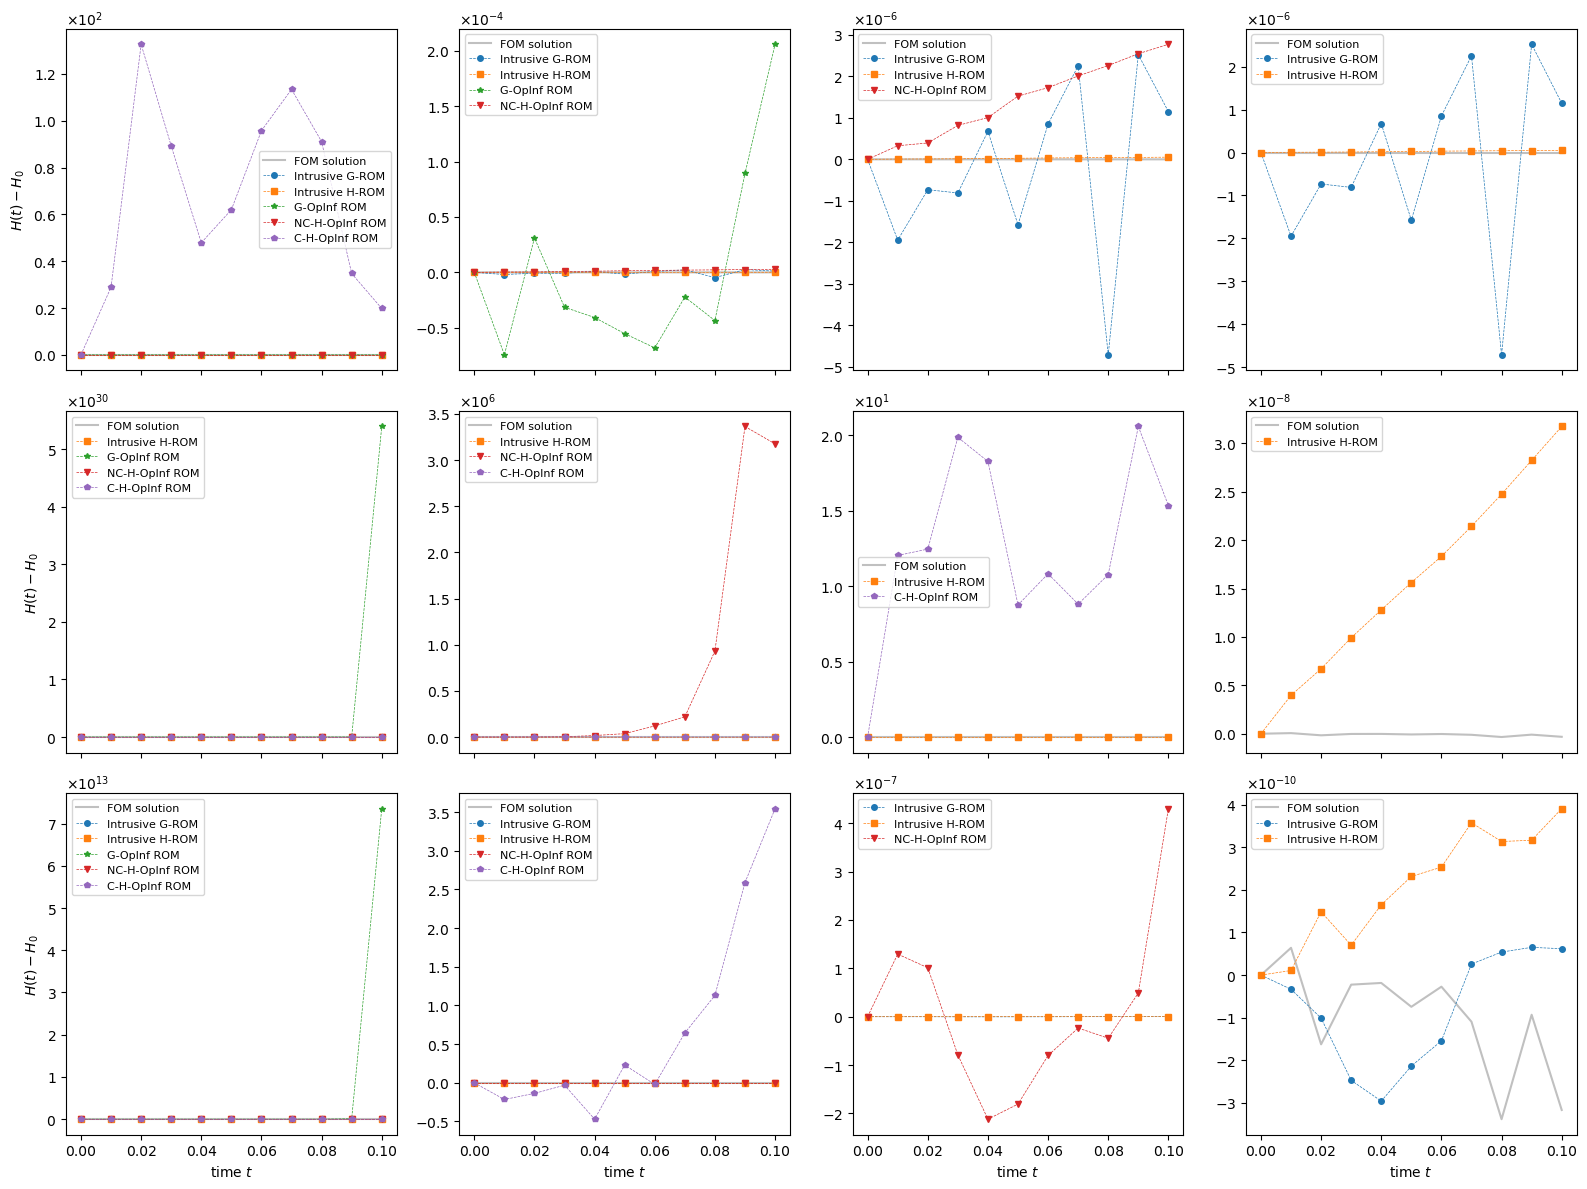

In [ ]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(3, 4, figsize=(16,12), sharex=True)

skip=20

titleList   = ['All', 
               'G-OpInf ROM',
               'C-H-OpInf ROM' , 
               'Other H-ROMs']

i,j = 0,11

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)


i,j = 1,-4

ax.flatten()[4].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[4].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[4].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[5].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[5].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[6].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[6].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[6].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[7].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
# ax.flatten()[7].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[7].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)

i,j = 2,-2

ax.flatten()[8].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[8].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[8].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[9].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[9].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[9].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[10].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[11].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[11].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[11].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)

for i in range(3):
    ax[i,0].set_ylabel(r'$H(t) - H_0$')

for i in range(4):
    ax[-1,i].set_xlabel('time $t$')

for i in range(12):
    # ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
plt.savefig(f'EnergyLinearElastic', transparent=True)
plt.show()


### Experiment testing effect of regularization

This is outdated.

In [ ]:
# from importlib import reload
# reload(ou)

# ### Exact solution
# Ttest     = 1e-1
# NtTest    = 201
# tTest     = np.linspace(0, Ttest, NtTest)
# ic        = data[0][:,0]
# Xac       = X
# # Xac = ru.integrate_Linear_HFOM(tTest, ic, Jsp, Asp)[0]
# # exactE = Hamil(Xac, Asp)

# Xd, gH, L, A = xDotData, gradHData, Jsp, Asp

# ### Parameters
# oneShot = False
# UmatList    = [UU, [UU2,UU2], [UUq,UUp]]
# # UmatList    = [UU]
# MCtog       = True
# if MCtog:
#     UmatListMC = [UUmc, [UU2mc, UU2mc], [UUqmc, UUpmc]]
#     # UmatListMC = [[UUqmc, UUpmc]]
#     # UmatListMC = [UUmc]


# nList = [4*(11+1), 4*(15+1), 4*(15+1)]
# regList=[10**i for i in range(14)]

# eOpH   = np.zeros((3, 14))
# eOp    = np.zeros((3, 14))
# eOpA   = np.zeros((3, 14))
# eOpAbz   = np.zeros((3, 14))

# # HamileIntG = np.zeros((3, len(nList), NtTest))
# # HamileIntH = np.zeros((3, len(nList), NtTest))
# # HamileOpH  = np.zeros((3, len(nList), NtTest))
# # HamileOp   = np.zeros((3, len(nList), NtTest))
# # HamileOpA  = np.zeros((3, len(nList), NtTest))

# # XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
# # XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
# XrecOp   = np.zeros((14, 2*Nover2, NtTest))
# XrecOpH  = np.zeros((14, 2*Nover2, NtTest))
# XrecOpA  = np.zeros((14, 2*Nover2, NtTest))
# XrecOpAbz  = np.zeros((14, 2*Nover2, NtTest))

# fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

# titleList   = ['Ordinary POD ($n=48$)', 
#                'Cotangent Lift POD ($n=64$)',
#                'Block (q,p) POD ($n=64$)']

# alpha=1

# for l,n in enumerate(nList):

#     OpInfLists  = ou.build_OpInf_stuff(UmatList[l], X[:,:Nt], Xd[:,:Nt], 
#                                         gH[:,:Nt], L, n)
#     OpLists     = ru.build_Linear_ROM_Ops(UmatList[l], L, A, ic, MC=False)
#     OpListOL    = list(OpLists[0])

#     if MCtog:
#         OpInfListMC = ou.build_OpInf_stuff(UmatListMC[l], X[:,:Nt], Xd[:,:Nt], 
#                                             gH[:,:Nt], L, n, MC=True)
#         OpListsMC   = ru.build_Linear_ROM_Ops(UmatListMC[l], L, A, ic, MC=True)
#         OpListMCOL  = list(OpListsMC[0])

#     for i, reg in enumerate(regList):

#         DhatOpFull            = ou.G_OpInf(OpInfLists[-1], n, None, eps=1.0e-7*reg)

#         if not oneShot:
#             # Compute for each n
#             DhatOp  = ou.G_OpInf(OpInfLists[-1], n, None, eps=1.0e-7*reg)
#             if MCtog:
#                 LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=1.0e-7*reg)
#             else:
#                 LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=1.0e-7*reg)
            
#             AhatOp        = ou.C_H_OpInf(OpInfLists[1], n, None, eps=1.0e-7*reg, BorisZhu=False)
#             AhatOpbz      = ou.C_H_OpInf(OpInfLists[1], n, None, eps=1.0e-7*reg, BorisZhu=True)
        
#         if MCtog:
#             OpListMCOL[0] = LhatHOpMC
#             try:
#                 XrecOpH[i]  = ru.integrate_Linear_ROM(tTest, OpListMCOL, ic, UmatListMC[l],
#                                                     n, MC=True, Hamiltonian=True)
#             except ValueError:
#                 pass
#         else:
#             OpListOL[0] = LhatHOp
#             try:
#                 XrecOpH[i]  = ru.integrate_Linear_ROM(tTest, OpListOL, ic, UmatList[l],
#                                                     n, MC=False, Hamiltonian=True)
#             except ValueError:
#                 pass

#         try:
#             XrecOp[i]   = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UmatList[l])
#             XrecOpA[i]  = ru.integrate_OpInf_ROM(tTest, AhatOp, ic, UmatList[l], L)
#             XrecOpAbz[i]  = ru.integrate_OpInf_ROM(tTest, AhatOpbz, ic, UmatList[l], L)
#         except ValueError:
#             pass

#         eOp[l,i]   = ru.relError(Xac, XrecOp[i])
#         eOpH[l,i]  = ru.relError(Xac, XrecOpH[i])
#         eOpA[l,i]  = ru.relError(Xac, XrecOpA[i])
#         eOpAbz[l,i]  = ru.relError(Xac, XrecOpAbz[i])
    
#     # Print error magnitudes
#     print(f'{l} the relative L2 errors for generic OpInf are {eOp[l]}')
#     print(f'{l} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[l]}')
#     print(f'{l} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[l]}')
#     print(f'{l} the relative L2 errors for boris/zhu Hamiltonian OpInf are {eOpAbz[l]}' + '\n')

    
#     listo = [-(14-j) for j in range(14)]
#     ax.flatten()[l].semilogy(listo, eOp[l],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
#     ax.flatten()[l].semilogy(listo, eOpH[l], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
#     ax.flatten()[l].semilogy(listo, eOpA[l], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
#     # if l==1:
#     #     ax.flatten()[1].semilogy(listo, eOpAbz[l], label='H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
#     ax.flatten()[l].set_xlabel(r'$\log_{10}(\eta)$')
#     ax.flatten()[l].set_title(f'{titleList[l]}')
#     ax.flatten()[l].legend(prop={'size':8}, loc=4)
#     ax.flatten()[l].set_ylim([10**-8, 10.])

# ax.flatten()[0].set_ylabel(r'relative $L^2$ error')

# plt.tight_layout()
# # plt.savefig(f'PlatePlotReg', transparent=True)
# plt.show()

# # 16 - pqblock
# # 24 - cotlift
# # 12 - ord


In [ ]:
exo_copy.close()

Closing exodus file: beam_vecIC_100_written.e
